## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

In [1]:
!git clone https://github.com/cayang17/pca_assignment
%cd pca_assignment

Cloning into 'pca_assignment'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 7 (from 1)
Receiving objects: 100% (9/9), 1.54 MiB | 5.30 MiB/s, done.
/content/pca_assignment


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [2]:
import pickle
with open('data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

Top 20 tokens:
'new': 1365
'date': 1202
'get': 1052
'please': 1022
'enron': 927
'like': 923
'2002': 869
'would': 806
'one': 798
'message': 795
'call': 740
'free': 691
'software': 680
'dear': 651
'know': 644
'email': 629
'url:': 625
'time': 609
'start': 604
'linguistics': 598


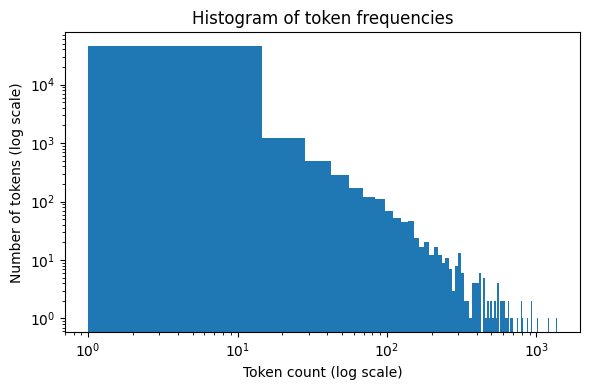

In [16]:
print("Top 20 tokens:")
for tok, cnt in token_freq[:20]:
    print(f"{tok!r}: {cnt}")

counts = np.array([c for _, c in token_freq])

plt.figure(figsize=(6, 4))
plt.hist(counts, bins=100)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Token count (log scale)")
plt.ylabel("Number of tokens (log scale)")
plt.title("Histogram of token frequencies")
plt.tight_layout()
plt.show()

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [17]:
df = pd.read_parquet("data/Phishing_clean.parquet")

df.head()

y = df["Email Type"]

# One-hot encoded token features
X = df.drop(columns=["Email Type"])

print("X shape:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Training R²: {r2_train:.4f}")
print(f"Test R²:     {r2_test:.4f}")

# Create a series of coefficients indexed by token
coef_series = pd.Series(linreg.coef_, index=X.columns)

coef_sorted = coef_series.reindex(
    coef_series.abs().sort_values(ascending=False).index
)

# Display top 10 most influential tokens
coef_sorted.head(10)


X shape: (18634, 2711)
Training R²: 0.7663
Test R²:     0.6670


,0
background-image:,-1.049625
localized,0.820562
aging,0.764463
inkjet,-0.733725
form.,0.584518
thermal,0.581701
"helvetica,",0.564463
xanaax,0.540181
#000000;,0.531403
#331f30;,0.531403


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

Explained variance ratio (PC1, PC2): [0.01113089 0.00861213]


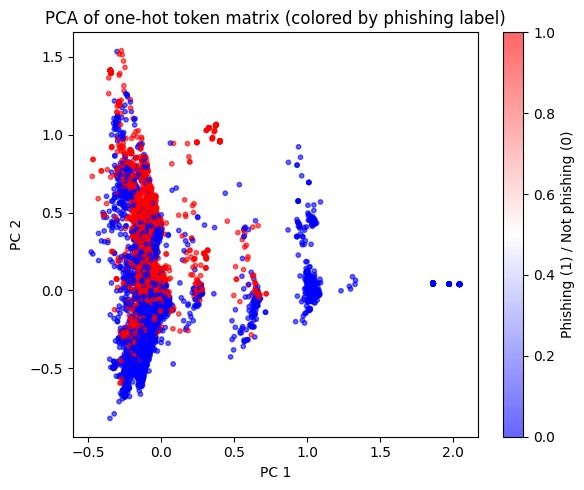

In [18]:
# Run PCA on the full one-hot matrix to 2 components
pca_2 = PCA(n_components=2, random_state=0)
X_pca_2 = pca_2.fit_transform(X)

print("Explained variance ratio (PC1, PC2):", pca_2.explained_variance_ratio_)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_pca_2[:, 0],
    X_pca_2[:, 1],
    c=y,
    cmap="bwr",
    alpha=0.6,
    s=10,
)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA of one-hot token matrix (colored by phishing label)")
plt.colorbar(scatter, label="Phishing (1) / Not phishing (0)")
plt.tight_layout()
plt.show()

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [19]:
n_components = 2610

# Fit PCA on training data only
pca = PCA(n_components=n_components, random_state=0)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Original feature dimension:", X_train.shape[1])
print("PCA dimension:", X_train_pca.shape[1])
print("Total variance explained by first 2610 PCs:",
      pca.explained_variance_ratio_.sum())

# Linear regression on the PCA features
linreg_pca = LinearRegression()
linreg_pca.fit(X_train_pca, y_train)

y_train_pred_pca = linreg_pca.predict(X_train_pca)
y_test_pred_pca = linreg_pca.predict(X_test_pca)

r2_train_pca = r2_score(y_train, y_train_pred_pca)
r2_test_pca = r2_score(y_test, y_test_pred_pca)

print(f"\nPCA + Linear Regression (2610 PCs)")
print(f"Train R^2 (PCA): {r2_train_pca:.4f}")
print(f"Test  R^2 (PCA): {r2_test_pca:.4f}")

print("\nOne-hot regression (from Q2) for comparison:")
print(f"Train R^2 (one-hot): {r2_train:.4f}")
print(f"Test  R^2 (one-hot): {r2_test:.4f}")


Original feature dimension: 2711
PCA dimension: 2610
Total variance explained by first 2610 PCs: 0.9998515771369086

PCA + Linear Regression (2610 PCs)
Train R^2 (PCA): 0.7654
Test  R^2 (PCA): 0.6704

One-hot regression (from Q2) for comparison:
Train R^2 (one-hot): 0.7663
Test  R^2 (one-hot): 0.6670


### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components instead of the original token features emphasizes the challenge of extremely high dimensionality in this dataset. With thousants of one-hot encoded tokens, a regression model can easily overfit the training data by assigning large coefficients to rare or highly correlated words.

By regressiing on the principal componenets, the model becomes more stable and less sensitive to noise from infrequent or redundant tokens. This typically reduces overfitting and leads to better generalization on the test set, even if training performance is slightly lower. PCA acts as a form of regularization.